# CNN model for predicting Sex from ECGs

In [1]:
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')


[]

### Loading raw data into mutable Datframes

In [2]:
ptb = pd.read_csv('C:/Users/varun/ECG_Research_Project/ECG_Model/data/ptbxl_database.csv')
ptb.head()
len(ptb)

21799

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path = 'C:/Users/varun/ECG_Research_Project/ECG_Model/data'
sampling_rate=100

In [5]:
# load and convert annotation data
Y = pd.read_csv(path+'/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))



In [6]:


# Load raw signal data
X = load_raw_data(Y, sampling_rate, 'C:/Users/varun/ECG_Research_Project/ECG_Model/data/')

In [7]:
X.shape, Y.shape

((21799, 1000, 12), (21799, 27))

In [8]:
X[0].shape


(1000, 12)

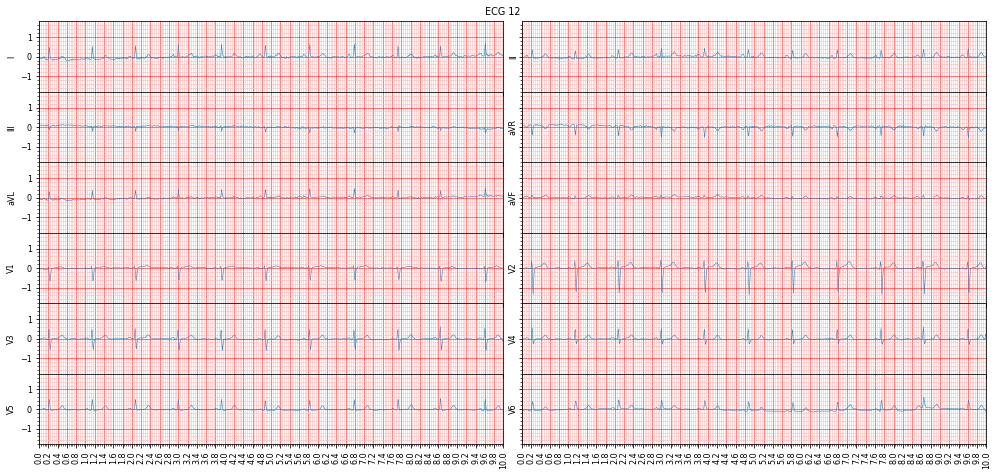

In [162]:
ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)


In [10]:

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [11]:
Y_pd = pd.DataFrame(Y)
Y_pd

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


### Visualizing the Data

Text(0.5, 1.0, 'Distribution of Sex')

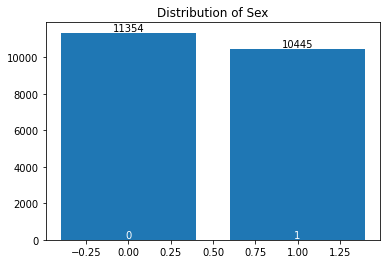

In [12]:
# Distribution of Male and Female ECGs
uniques, counts = np.unique(Y_pd.sex, return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

Text(0.5, 1.0, 'Distribution of Diagnostic Superclasses')

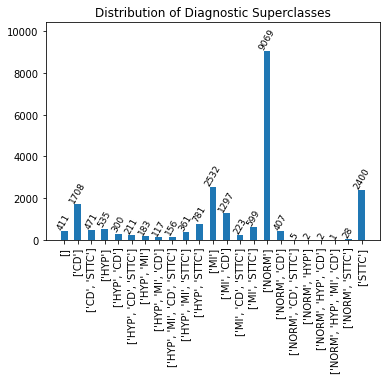

In [13]:
diag_uniques, diag_counts = np.unique(Y_pd.diagnostic_superclass, return_counts=True)
temp = [str(i) for i in diag_uniques]
plt.bar(temp, diag_counts, width = 0.5)
for i in range(len(diag_uniques)):
    plt.text(i, diag_counts[i], str(diag_counts[i]), ha='center', va='bottom', size = 9, rotation = 60)

plt.xticks(rotation = 90)
plt.ylim(0, max(diag_counts) + max(diag_counts)*0.15)
plt.title("Distribution of Diagnostic Superclasses")

### Preprocessing

In [14]:
# Normalization
# Compute mean and standard deviation along axis 1 and 2
X_mean = np.mean(X, axis=(-1), keepdims=True)
X_std = np.std(X, axis=(-1), keepdims= True)

X_mean.shape

(21799, 1000, 1)

In [15]:
# Normalize data by subtracting mean and dividing by standard deviation
X_norm = (X - X_mean) / X_std
X_norm.shape


(21799, 1000, 12)

In [16]:
X_norm[(1,2,3),:,:]

array([[[-0.59844998,  0.78021416,  0.73906   , ...,  1.33579523,
          0.21434455,  0.26578724],
        [-0.80632554,  0.79066873,  1.02552083, ...,  1.26037293,
          0.09785504,  0.16831067],
        [-1.06792948,  0.80903748,  1.49510127, ...,  1.00320648,
         -0.2135859 , -0.0970845 ],
        ...,
        [ 0.77931775,  1.18199958,  1.00609885, ..., -0.94480011,
         -0.11181568,  0.37663592],
        [-0.66311156,  0.72851435,  1.91303144, ..., -0.49597111,
         -0.11445487,  0.26342788],
        [-1.31195248,  0.13640338,  1.86252611, ..., -1.11354757,
         -0.73161811, -0.30504755]],

       [[ 0.37754233, -0.67606418, -0.04390027, ..., -1.1817953 ,
         -0.61284779, -0.40212648],
        [ 0.22181153, -0.52347522,  0.22181153, ..., -1.24746807,
         -0.71512038, -0.4808874 ],
        [-0.40078602, -0.47186138,  0.80749499, ..., -0.96938885,
         -0.68508744, -0.40078602],
        ...,
        [-0.15146323, -1.56114464, -1.36078383, ...,  

In [37]:

# Split data into train and test
test_fold =10
X_train = X_norm[(Y.strat_fold != test_fold)]
y_train = Y[Y.strat_fold != test_fold].sex

X_test = X_norm[(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].sex

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

y_train = y_train.idxmax(axis = 1).to_numpy()
y_test = y_test.idxmax(axis = 1).to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((19601, 1000, 12), (2198, 1000, 12), (19601,), (2198,), numpy.ndarray)

In [36]:
type(X_train)

numpy.ndarray

# Evaluating data distribution

Text(0.5, 1.0, 'Distribution of Sex')

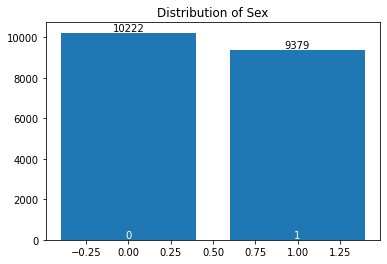

In [38]:
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

In [19]:
# # Reshaping for ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_model_8_8_8_8_8_8
# X_train = tf.reshape(X_train, (19601, 1000, 12,1))
# X_test = tf.reshape(X_test, (2198, 1000, 12,1))

# Model Creation

### Model 1
* Few Hidden layers
* Deafault 0.001 learning rate
* 2 layers of spatial analysis
* 1 Fully connected layer
* Relu and Sigmoid activations

In [80]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 10, kernel_size = 7, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 25, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history = ecg_sex_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
613/613 [==============================] - 7s 11ms/step - loss: 0.6442 - accuracy: 0.6609 - val_loss: 0.6079 - val_accuracy: 0.6824
Epoch 2/10
613/613 [==============================] - 7s 11ms/step - loss: 0.5650 - accuracy: 0.7350 - val_loss: 0.5612 - val_accuracy: 0.7134
Epoch 3/10
613/613 [==============================] - 7s 11ms/step - loss: 0.5220 - accuracy: 0.7623 - val_loss: 0.5548 - val_accuracy: 0.7288
Epoch 4/10
613/613 [==============================] - 7s 11ms/step - loss: 0.4883 - accuracy: 0.7815 - val_loss: 0.5421 - val_accuracy: 0.7411
Epoch 5/10
613/613 [==============================] - 7s 11ms/step - loss: 0.4610 - accuracy: 0.7977 - val_loss: 0.6185 - val_accuracy: 0.6993
Epoch 6/10
613/613 [==============================] - 7s 11ms/step - loss: 0.4366 - accuracy: 0.8089 - val_loss: 0.5808 - val_accuracy: 0.7234
Epoch 7/10
613/613 [==============================] - 7s 11ms/step - loss: 0.4045 - accuracy: 0.8230 - val_loss: 0.5631 - val_accuracy: 0.7338

### Model 2
* Modification of the number of neurons. 
* Adjusted learning rate slighlty

In [21]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 3, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_2 = ecg_sex_model_2.fit(X_train, y_train, epochs = 8, validation_data = (X_test, y_test))

Epoch 1/8
613/613 [==============================] - 9s 13ms/step - loss: 0.5700 - accuracy: 0.7072 - val_loss: 0.5923 - val_accuracy: 0.6852
Epoch 2/8
613/613 [==============================] - 8s 13ms/step - loss: 0.4839 - accuracy: 0.7719 - val_loss: 0.5110 - val_accuracy: 0.7507
Epoch 3/8
613/613 [==============================] - 8s 13ms/step - loss: 0.4295 - accuracy: 0.8012 - val_loss: 0.5124 - val_accuracy: 0.7530
Epoch 4/8
613/613 [==============================] - 8s 13ms/step - loss: 0.3833 - accuracy: 0.8250 - val_loss: 0.5310 - val_accuracy: 0.7434
Epoch 5/8
613/613 [==============================] - 8s 13ms/step - loss: 0.3293 - accuracy: 0.8475 - val_loss: 0.6485 - val_accuracy: 0.7075
Epoch 6/8
613/613 [==============================] - 8s 13ms/step - loss: 0.2668 - accuracy: 0.8763 - val_loss: 0.7255 - val_accuracy: 0.7247
Epoch 7/8
613/613 [==============================] - 8s 13ms/step - loss: 0.2113 - accuracy: 0.9012 - val_loss: 0.7496 - val_accuracy: 0.7366
Epoch 

### Model 3
* Additional spatial layer


**Key Issues at this time**
* The model appeared to be over fitting to the training data evidenced by the varying accuracies between training and testing

In [79]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_3 = ecg_sex_model_3.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
503/613 [=======================>......] - ETA: 1s - loss: 0.5455 - accuracy: 0.7205

KeyboardInterrupt: 

### Model 4
* Implemented learning rate scheduler callback
* Implemented early stop callback
* Additional spatial layer
* Weaved in batch normalization
* Implemented weight droppout

In [23]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_4.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model

history_4 = ecg_sex_model_4.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = early_stopper)

Epoch 1/12
613/613 [==============================] - 16s 23ms/step - loss: 0.5491 - accuracy: 0.7358 - val_loss: 0.5383 - val_accuracy: 0.7416
Epoch 2/12
613/613 [==============================] - 13s 22ms/step - loss: 0.4522 - accuracy: 0.7949 - val_loss: 0.4756 - val_accuracy: 0.7762
Epoch 3/12
613/613 [==============================] - 14s 23ms/step - loss: 0.4271 - accuracy: 0.8080 - val_loss: 0.5254 - val_accuracy: 0.7630
Epoch 4/12
613/613 [==============================] - 13s 21ms/step - loss: 0.4096 - accuracy: 0.8166 - val_loss: 0.4968 - val_accuracy: 0.7662
Epoch 5/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3976 - accuracy: 0.8247 - val_loss: 0.4502 - val_accuracy: 0.7880
Epoch 6/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3868 - accuracy: 0.8312 - val_loss: 0.4738 - val_accuracy: 0.7925
Epoch 7/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3724 - accuracy: 0.8355 - val_loss: 0.4704 - val_accuracy:

### Model 5
* 5 spatial layers each with their own batch normalization
* Modified learning rate
* Implemented Lasso L1 regularizer. 
* Early stopper in place

In [70]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)
tf.keras.backend.set_image_data_format('channels_first')


# Creating the model

ecg_sex_model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu', input_shape= (1000, 12)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_5.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_5 = ecg_sex_model_5.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = (early_stopper))

Epoch 1/12
613/613 [==============================] - 16s 24ms/step - loss: 1.8629 - accuracy: 0.7312 - val_loss: 0.5678 - val_accuracy: 0.7557
Epoch 2/12
294/613 [=============>................] - ETA: 7s - loss: 0.4921 - accuracy: 0.7971

KeyboardInterrupt: 

### Model 6
* Wanted to see if model's performance was proportional to training time
* Doubled the epochs and disabled the early stopper


**Take aways**
* The model's training accuracy consistently grew with epochs
* The model's testing accuracy fluctuated and plateaued around 0.8
* The number of epochs has little effect on testing accuracy when the model overfits.

In [57]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_6 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_6.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_6 = ecg_sex_model_6.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test))

Epoch 1/25
613/613 [==============================] - 26s 34ms/step - loss: 3.4477 - accuracy: 0.7359 - val_loss: 1.2253 - val_accuracy: 0.7584
Epoch 2/25
613/613 [==============================] - 19s 31ms/step - loss: 1.1437 - accuracy: 0.7866 - val_loss: 1.1434 - val_accuracy: 0.7862
Epoch 3/25
613/613 [==============================] - 19s 31ms/step - loss: 1.0798 - accuracy: 0.7949 - val_loss: 1.0448 - val_accuracy: 0.7753
Epoch 4/25
613/613 [==============================] - 19s 30ms/step - loss: 0.9832 - accuracy: 0.8106 - val_loss: 0.9852 - val_accuracy: 0.7607
Epoch 5/25
613/613 [==============================] - 19s 32ms/step - loss: 0.9647 - accuracy: 0.8163 - val_loss: 1.0491 - val_accuracy: 0.7693
Epoch 6/25
613/613 [==============================] - 19s 31ms/step - loss: 0.9606 - accuracy: 0.8188 - val_loss: 0.9968 - val_accuracy: 0.7789
Epoch 7/25
613/613 [==============================] - 19s 31ms/step - loss: 0.9470 - accuracy: 0.8238 - val_loss: 0.9709 - val_accuracy:

In [106]:
tf.debugging.disable_traceback_filtering
tf.config.list_physical_devices('GPU')
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_7 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=5, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_7.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= .0001),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_7 = ecg_sex_model_7.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test))

Epoch 1/25
613/613 [==============================] - 283s 458ms/step - loss: 61.0673 - accuracy: 0.6039 - val_loss: 22.1078 - val_accuracy: 0.5205
Epoch 2/25
613/613 [==============================] - 302s 493ms/step - loss: 19.0116 - accuracy: 0.6479 - val_loss: 16.9526 - val_accuracy: 0.5842
Epoch 3/25
332/613 [===============>..............] - ETA: 2:13 - loss: 17.0236 - accuracy: 0.6646

KeyboardInterrupt: 

In [100]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

def make_confusion_matrix(X_test, y_test, classes, model, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    cm = confusion_matrix(y_test, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=(str(model.name) + " for Confusion Matrix"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

### Visualization of data

69/69 [==============================] - 0s 5ms/step


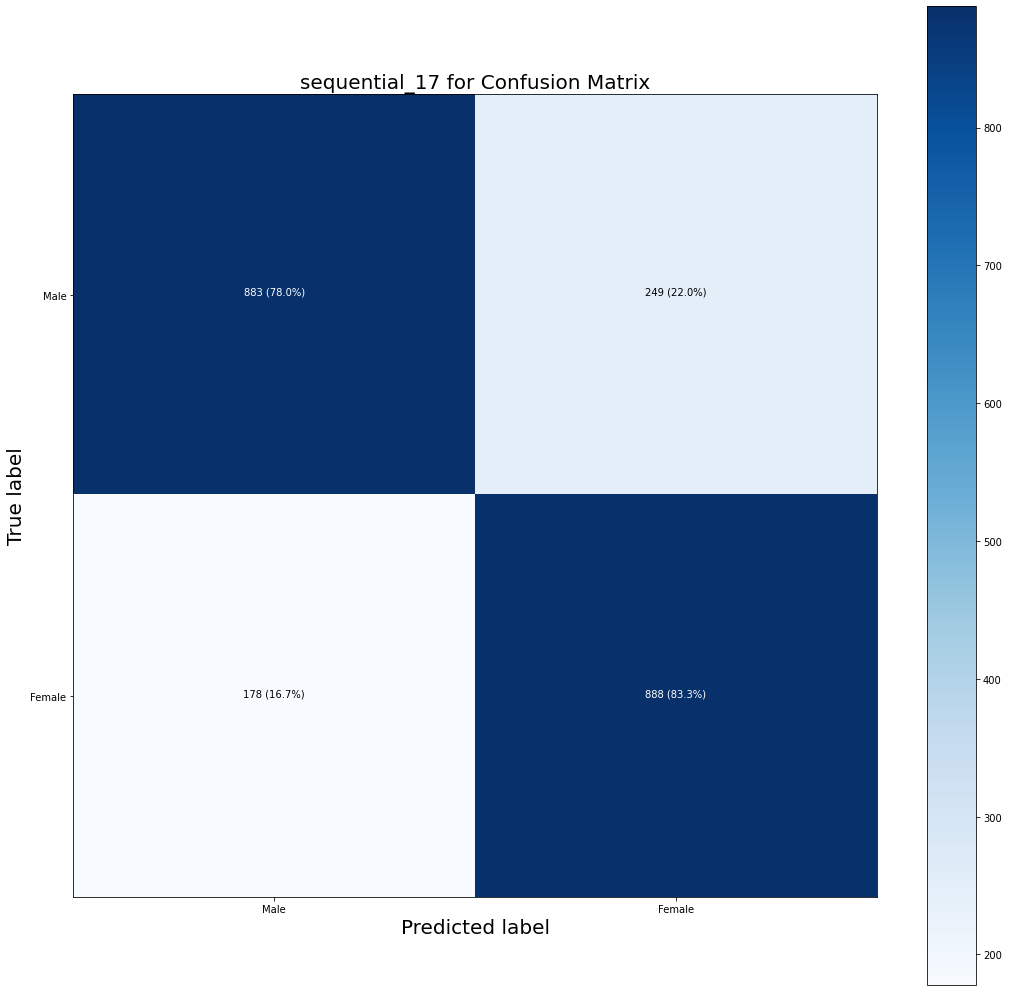

In [105]:
y_prob = ecg_sex_model_5.predict(X_test)
y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))


class_name = ['Male', 'Female']
make_confusion_matrix(X_test, y_test, model = ecg_sex_model_6, classes = class_name)



# Visualizing the ECGs with model interpretation
* External resources:
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2760216/

69/69 [==============================] - 0s 6ms/step


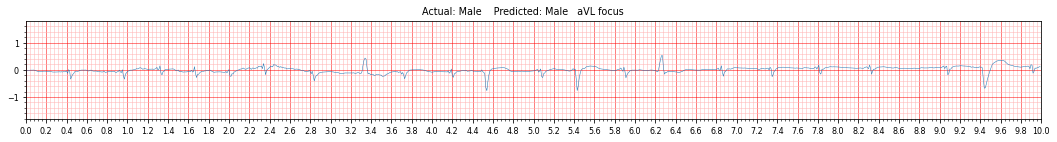

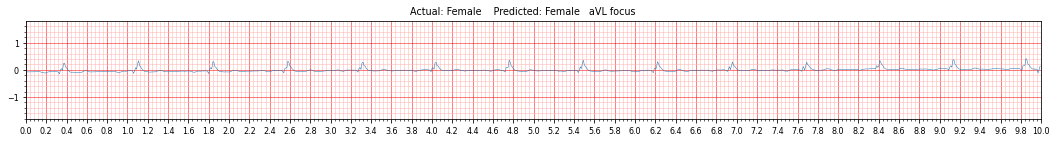

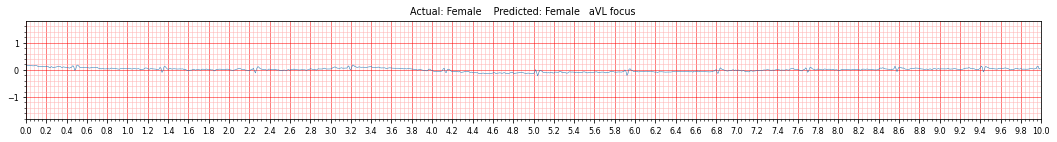

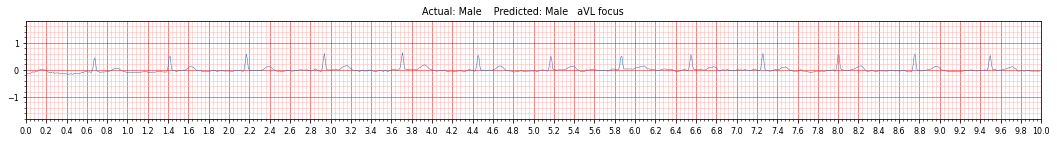

In [157]:
from random import choice

def visualize(y_test, X_test, model):
    class_names  = ['Male', 'Female']
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + class_names[y_test[ind]] + "    Predicted: " + class_names[y_pred[ind]])
        ecg_plot.plot_1(tf.transpose(X, (0,2,1))[ind][4], sample_rate=100, title = plot_title + "   aVL focus")

visualize(y_test, X_test, ecg_sex_model_6)


### Conclusions
* Attempt to train on the 500hz data set
* Use a cloud computing system to train larger models such as Google Collab. 
* Fine tune an existing high performance model such as ResNet. 